In [1]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
#Setting up the fot the dataset
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [4]:
%cd dataset2/

/content/drive/My Drive/Colab Notebooks/dataset2


In [5]:
!ls

data_dictionary.csv	summerOly_hosts.csv	    summerOly_programs.csv
summerOly_athletes.csv	summerOly_medal_counts.csv


In [7]:
import pandas as pd

In [8]:
data = pd.read_csv("summerOly_medal_counts.csv")

In [9]:
data

,Rank,NOC,Gold,Silver,Bronze,Total,Year
0,1,United States,11,7,2,20,1896
1,2,Greece,10,18,19,47,1896
2,3,Germany,6,5,2,13,1896
3,4,France,5,4,2,11,1896
4,5,Great Britain,2,3,2,7,1896
...,...,...,...,...,...,...,...
1430,84,Qatar,0,0,1,1,2024
1431,84,Refugee Olympic Team,0,0,1,1,2024
1432,84,Singapore,0,0,1,1,2024
1433,84,Slovakia,0,0,1,1,2024


## ARIMA模型预测

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

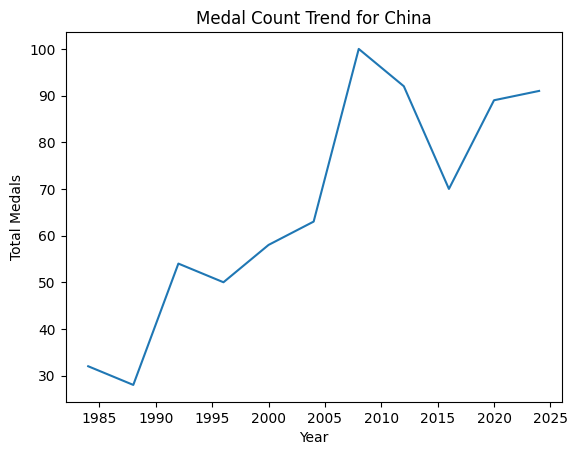

预测结果（未来6年）： 11    91.000002
12    90.999994
13    90.999995
14    90.999999
15    90.999999
16    90.999999
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

In [15]:
# 为每个国家选择数据进行预测
country = 'China'  # 选择一个国家（例如：中国）

# 筛选出目标国家的数据
country_data = data[data['NOC'] == country]

# 按年份排序，并使用 Total 奖牌数进行时间序列预测
country_data = country_data[['Year', 'Total']]
country_data.set_index('Year', inplace=True)

# 绘制数据趋势图
plt.plot(country_data)
plt.title(f'Medal Count Trend for {country}')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.show()

# 建立并训练 ARIMA 模型
model = ARIMA(country_data, order=(5, 1, 0))  # (p,d,q)
model_fit = model.fit()

# 预测未来几年奖牌数量
forecast = model_fit.forecast(steps=6)  # 预测未来6年（例如2023到2028年）

# 显示预测结果
print("预测结果（未来6年）：", forecast)

## LSTM模型

In [19]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [20]:
# 为每个国家选择数据进行预测
country = 'China'
country_data = data[data['NOC'] == country]

# 按年份排序，并使用 Total 奖牌数
country_data = country_data[['Year', 'Total']]
country_data.set_index('Year', inplace=True)

# 归一化奖牌数量
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(country_data[['Total']])

# 准备训练数据
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5  # 使用过去5年的数据预测未来
X, Y = create_dataset(scaled_data, look_back)

# 分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Reshape 数据以适配 LSTM 输入格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 创建并训练 LSTM 模型
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=False, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)

# 预测未来 6 年的数据
predicted_medals = model.predict(X_test)

# 反归一化
predicted_medals = scaler.inverse_transform(predicted_medals)
print("LSTM 预测的未来奖牌数量：", predicted_medals)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6055
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5811
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5573
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.5340
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.5113
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.4890
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4671
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4458
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4248
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4042
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3839
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3640
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3444
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3251
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3061
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/st

## 线性回归模型

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
# 为每个国家选择数据进行预测
country = 'China'
country_data = data[data['NOC'] == country]

# 按年份排序，并使用 Total 奖牌数
country_data = country_data[['Year', 'Total']]

# 创建特征和标签
X = country_data['Year'].values.reshape(-1, 1)  # 年份作为特征
y = country_data['Total'].values  # 总奖牌数作为标签

# 拟合线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测 2028 年的奖牌数量
year_to_predict = np.array([[2028]])
predicted_medals = model.predict(year_to_predict)

print(f'预测 {country} 在 2028 年的奖牌数: {predicted_medals[0]}')

预测 China 在 2028 年的奖牌数: 104.9818181818182


## 随机森林模型

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

均方误差 (MSE): 73.09723333333334


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29260 (\N{CJK UNIFIED IDEOGRAPH-724C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas

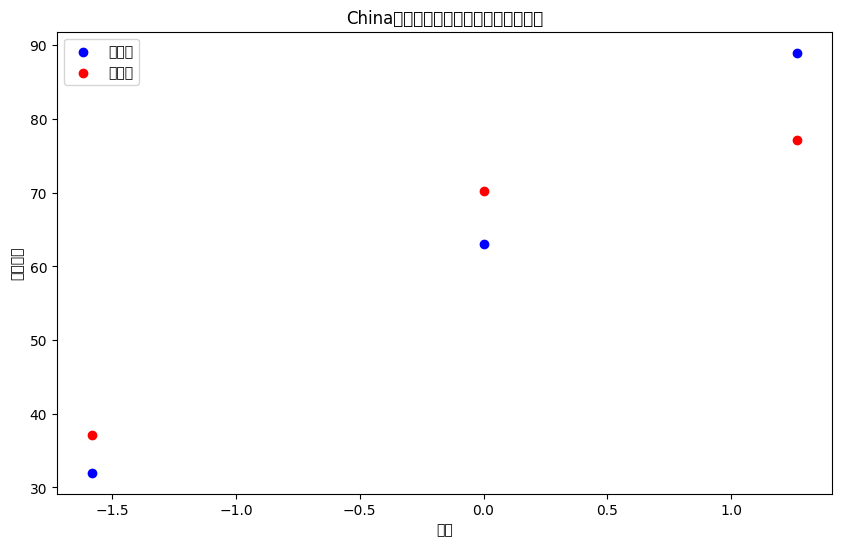

预测 China 在 2028 年的奖牌数: 86.33


In [24]:
# 选择需要预测的国家（例如：中国）
country = 'China'
country_data = data[data['NOC'] == country]

# 按年份排序，并选择 Total 奖牌数
country_data = country_data[['Year', 'Total']]
country_data.set_index('Year', inplace=True)

# 特征和目标变量
X = country_data.index.values.reshape(-1, 1)  # 年份作为特征
y = country_data['Total'].values  # 总奖牌数作为目标变量

# 数据标准化（可选，但有助于提高随机森林的效果）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建并训练随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 预测测试集的奖牌数量
y_pred = rf_model.predict(X_test)

# 计算并输出均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差 (MSE): {mse}")

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='实际值')
plt.scatter(X_test, y_pred, color='red', label='预测值')
plt.title(f'{country}的奖牌数量预测（随机森林回归）')
plt.xlabel('年份')
plt.ylabel('总奖牌数')
plt.legend()
plt.show()

# 使用训练好的模型预测 2028 年的奖牌数量
year_to_predict = np.array([[2028]])
year_to_predict_scaled = scaler.transform(year_to_predict)
predicted_medals = rf_model.predict(year_to_predict_scaled)

print(f'预测 {country} 在 2028 年的奖牌数: {predicted_medals[0]}')

## 神经网络模型

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 5150.0605 - val_loss: 4300.1646
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 5146.5229 - val_loss: 4296.8008
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 5142.9551 - val_loss: 4293.4131
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 5139.4028 - val_loss: 4290.0693
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 5135.8916 - val_loss: 4286.7090
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 5132.3452 - val_loss: 4283.2456
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 5128.7607 - val_loss: 4279.7461
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 5125.1943 - val_loss: 4276.2178
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 5121.6270 - val_loss: 4272.6719
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 5118.1729 - val_loss: 4269.1821
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 5114.7754 - val_loss: 4265.9199
Epoch 12/100

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32476 (\N{CJK UNIFIED IDEOGRAPH-7EDC}) missing from font(s) DejaVu Sans.
  fig.canvas

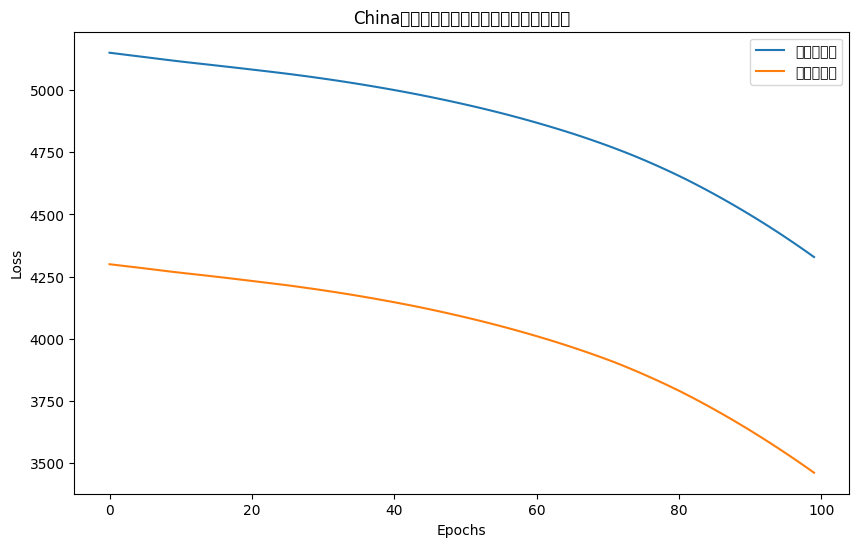

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
均方误差 (MSE): 3462.383544921875


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29260 (\N{CJK UNIFIED IDEOGRAPH-724C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas

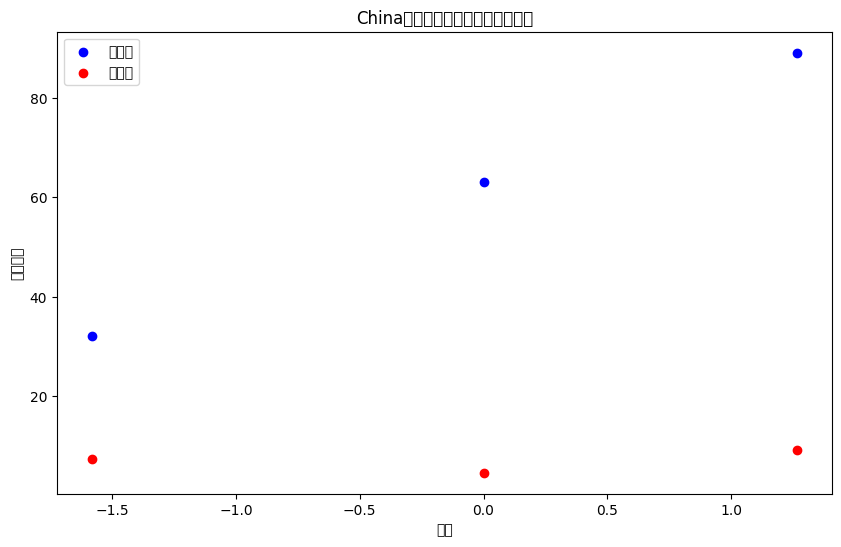

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
预测 China 在 2028 年的奖牌数: 12.122482299804688


In [26]:
# 选择需要预测的国家（例如：中国）
country = 'China'
country_data = data[data['NOC'] == country]

# 按年份排序，并选择 Total 奖牌数
country_data = country_data[['Year', 'Total']]
country_data.set_index('Year', inplace=True)

# 特征和目标变量
X = country_data.index.values.reshape(-1, 1)  # 年份作为特征
y = country_data['Total'].values  # 总奖牌数作为目标变量

# 数据标准化（可选，但有助于提高神经网络的效果）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_dim=1),  # 输入层和第一个隐藏层
    tf.keras.layers.Dense(units=32, activation='relu'),  # 第二个隐藏层
    tf.keras.layers.Dense(units=1)  # 输出层，预测奖牌数量
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# 绘制训练过程中的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练集损失')
plt.plot(history.history['val_loss'], label='验证集损失')
plt.title(f'{country}的神经网络奖牌数量预测（训练过程）')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 预测测试集的奖牌数量
y_pred = model.predict(X_test)

# 计算并输出均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差 (MSE): {mse}")

# 绘制实际值与预测值的对比图
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='实际值')
plt.scatter(X_test, y_pred, color='red', label='预测值')
plt.title(f'{country}的奖牌数量预测（神经网络）')
plt.xlabel('年份')
plt.ylabel('总奖牌数')
plt.legend()
plt.show()

# 使用训练好的模型预测 2028 年的奖牌数量
year_to_predict = np.array([[2028]])
year_to_predict_scaled = scaler.transform(year_to_predict)
predicted_medals = model.predict(year_to_predict_scaled)

print(f'预测 {country} 在 2028 年的奖牌数: {predicted_medals[0][0]}')